In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from distutils.dir_util import copy_tree, remove_tree #copy & remove dictionary tree
from random import randint #generate random int

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Lambda, Dense, Flatten, Dropout
)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from imblearn.over_sampling import SMOTE


In [2]:
#Defining Data Path
dataset_path = r"C:\Users\hrish\Downloads\archive (1)\combined_images"

#copying processed image
working_copy_path = r"C:\Users\hrish\Downloads\archive (1)\processed_images"


if os.path.exists(working_copy_path):
    remove_tree(working_copy_path)

os.makedirs(working_copy_path)
copy_tree(dataset_path, working_copy_path)

print("Copied dataset folders:", os.listdir(working_copy_path))


Copied dataset folders: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [3]:
# Class labels
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Image dimensions
image_size = 176
input_shape = (image_size, image_size)

# Augmentation parameters
zoom_range = [0.99, 1.01]
brightness_range = [0.8, 1.2]
use_horizontal_flip = True
fill_strategy = "constant"
channel_format = "channels_last"

# Image data generator with augmentation
image_generator = ImageDataGenerator(
    rescale=1.0 / 255,
    brightness_range=brightness_range,
    zoom_range=zoom_range,
    horizontal_flip=use_horizontal_flip,
    fill_mode=fill_strategy,
    data_format=channel_format
)


In [4]:
batch_size = 5200  

train_dataset = image_generator.flow_from_directory(
    directory=dataset_path,  
    target_size=input_shape,        
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'        
)


Found 44000 images belonging to 4 classes.


In [5]:
x_batch, y_batch = next(train_dataset)
print("Images shape:", x_batch.shape)
print("Labels shape:", y_batch.shape)


Images shape: (5200, 176, 176, 3)
Labels shape: (5200, 4)


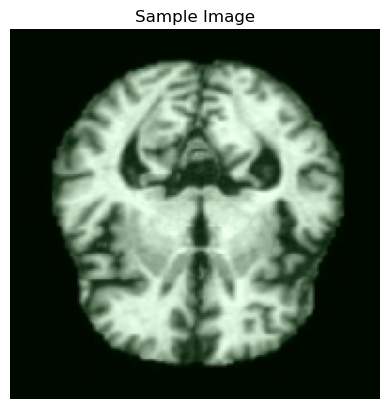

In [6]:
import matplotlib.pyplot as plt

plt.imshow(x_batch[0])
plt.title("Sample Image")
plt.axis("off")
plt.show()


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint

def show_images(generator, class_names=None, grid=3):
    # Get a batch of images and labels
    x_batch, y_batch = next(generator)
    
    if class_names is None:
        class_names = list(generator.class_indices.keys())

    plt.figure(figsize=(grid * 3, grid * 3))

    for i in range(grid * grid):
        ax = plt.subplot(grid, grid, i + 1)
        idx = randint(0, len(x_batch) - 1)

        image = x_batch[idx]
        label_idx = np.argmax(y_batch[idx])

        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Class: {class_names[label_idx]}", fontsize=10)

    plt.tight_layout()
    plt.show()


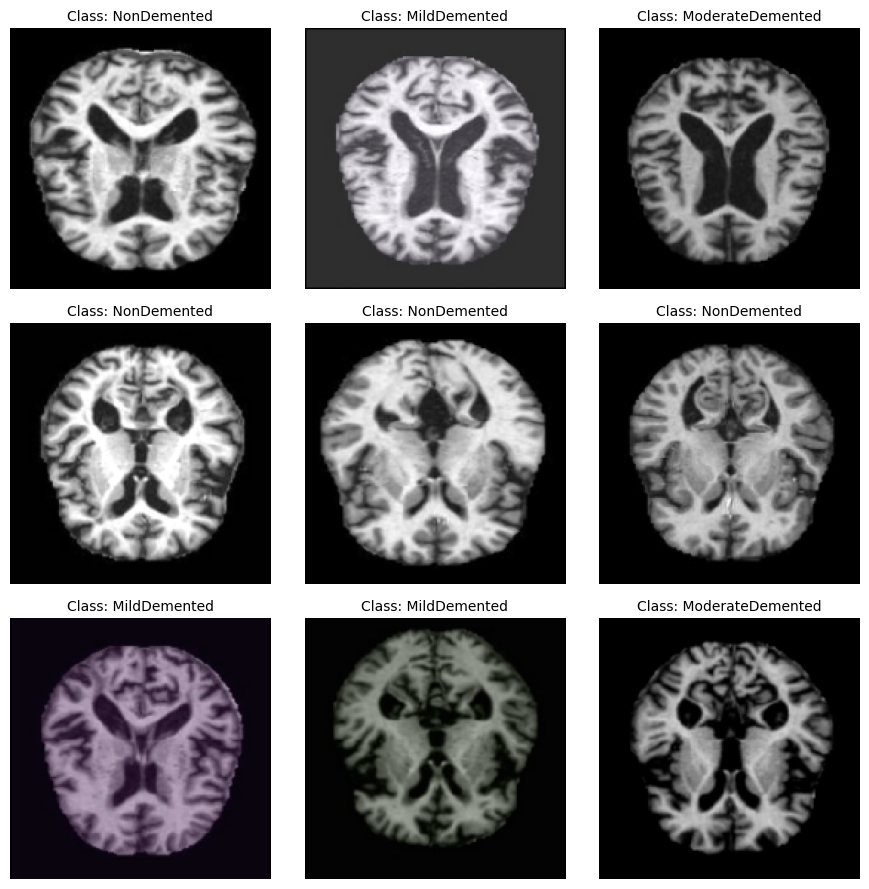

In [8]:
class_names = list(train_dataset.class_indices.keys())
show_images(train_dataset, class_names=class_names)


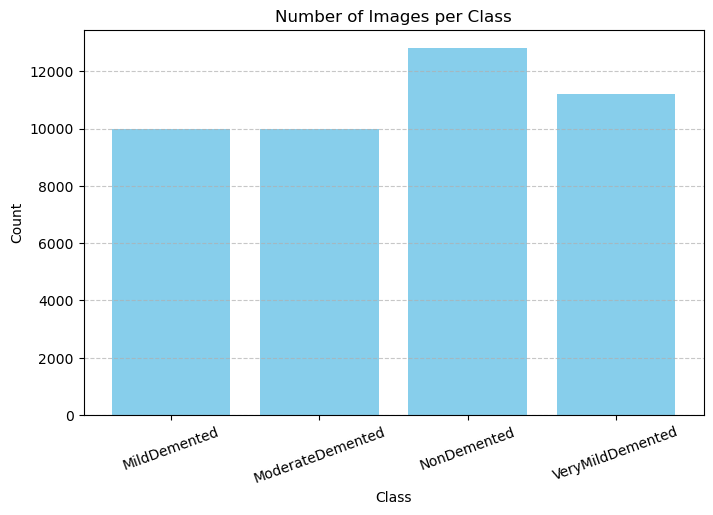

In [9]:
#Class Distribution plot
import os


data_dir = r"C:\Users\hrish\Downloads\archive (1)\combined_images"
classes = os.listdir(data_dir)
counts = [len(os.listdir(os.path.join(data_dir, cls))) for cls in classes]

plt.figure(figsize=(8,5))
plt.bar(classes, counts, color='skyblue')
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=20)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


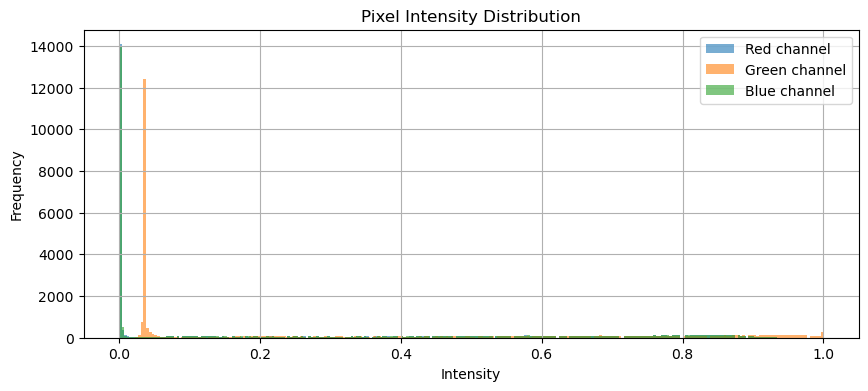

In [10]:
sample_img = x_batch[0]  #Normalized (0-1)
plt.figure(figsize=(10,4))

for i, color in enumerate(['Red', 'Green', 'Blue']):
    plt.hist(sample_img[:, :, i].ravel(), bins=256, alpha=0.6, label=f'{color} channel')

plt.title("Pixel Intensity Distribution")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

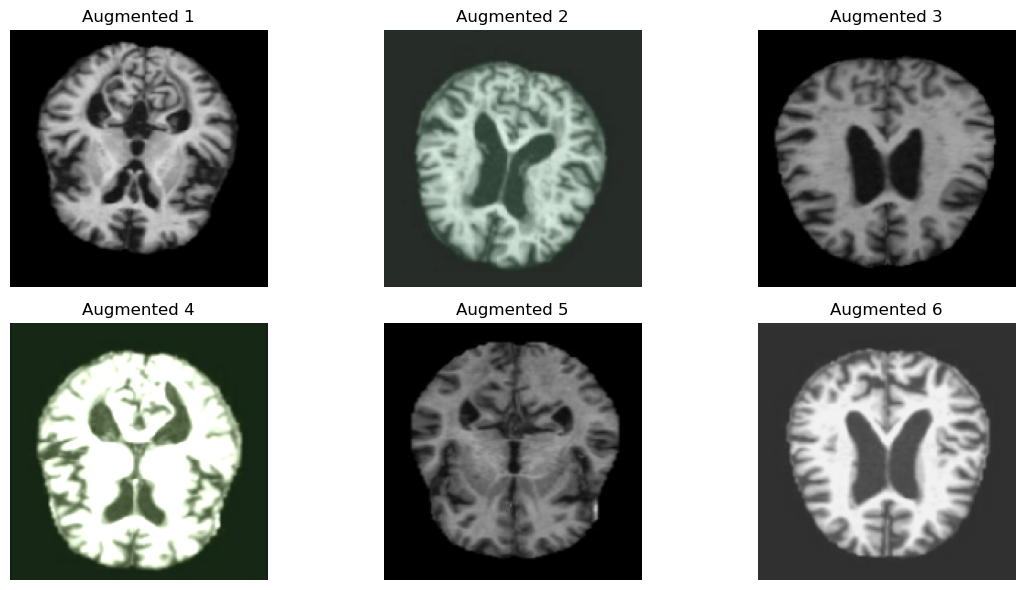

In [11]:
aug_generator = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.8, 1.2],
    zoom_range=[0.95, 1.05],
    horizontal_flip=True
)

aug_iter = aug_generator.flow(x_batch * 255.0, y_batch, batch_size=1)

plt.figure(figsize=(12, 6))
for i in range(6):
    img_augmented, _ = next(aug_iter)
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(img_augmented[0])
    plt.axis("off")
    plt.title(f"Augmented {i+1}")
plt.tight_layout()
plt.show()


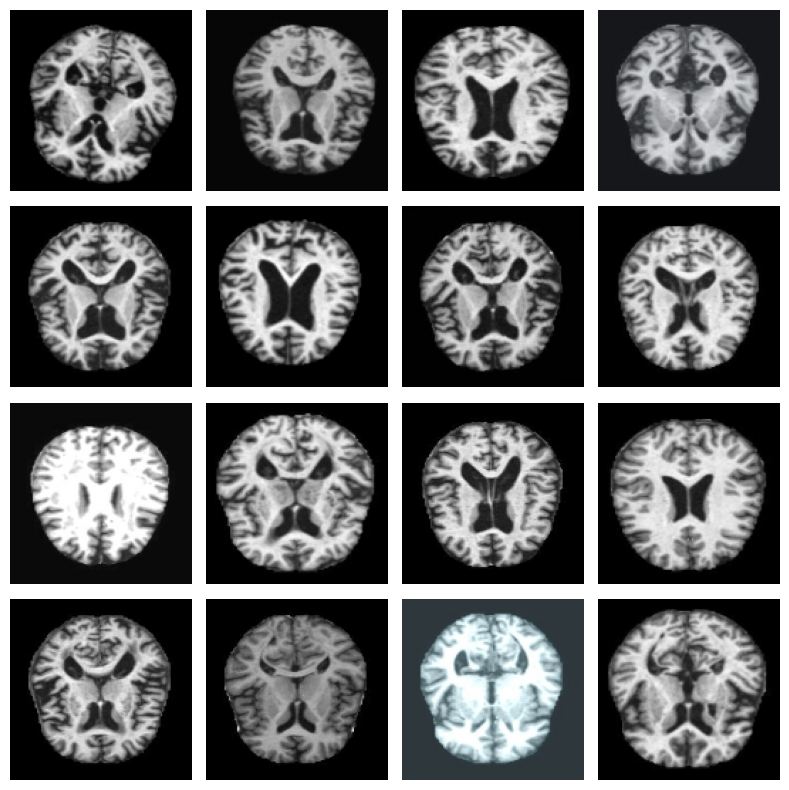

In [12]:
import random
def plot_class_samples(data_dir, class_names, samples_per_class=4):
    plt.figure(figsize=(samples_per_class * 2, len(class_names) * 2))

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        images = os.listdir(class_path)
        selected = random.sample(images, samples_per_class)

        for j, img_name in enumerate(selected):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))

            ax = plt.subplot(len(class_names), samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(img)
            plt.axis("off")
            if j == 0:
                ax.set_ylabel(class_name, size='large')
    
    plt.tight_layout()
    plt.show()

plot_class_samples(data_dir, class_names)


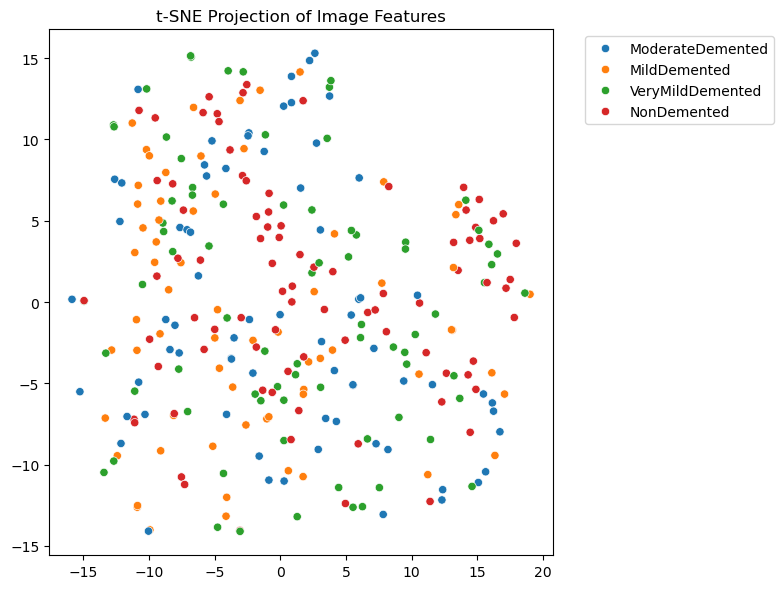

In [13]:
from sklearn.manifold import TSNE
import seaborn as sns

# Flatten and sample images
n_samples = 300
x_flat = x_batch.reshape(x_batch.shape[0], -1)
x_sample = x_flat[:n_samples]
y_sample = y_batch[:n_samples]
labels = np.argmax(y_sample, axis=1)

# Reduce dimensions
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
x_tsne = tsne.fit_transform(x_sample)


plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_tsne[:, 0], y=x_tsne[:, 1], hue=[class_names[l] for l in labels], palette='tab10')
plt.title("t-SNE Projection of Image Features")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [14]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(4, 4))
img_display = ax.imshow(np.zeros_like(x_batch[0]))
ax.axis("off")
aug_iter = aug_generator.flow(x_batch*255.0, y_batch, batch_size=1)

def update(frame):
    img, _ = next(aug_iter)
    img_display.set_data(img[0])
    return [img_display]

ani = animation.FuncAnimation(fig, update, frames=20, interval=300)
plt.close()
from IPython.display import HTML
HTML(ani.to_jshtml())

In [15]:
train_data, train_labels = next(train_dataset)
print(train_data.shape, train_labels.shape)

(5200, 176, 176, 3) (5200, 4)


In [16]:
#Resampling data
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, image_size * image_size * 3), train_labels)

train_data = train_data.reshape(-1, image_size, image_size, 3)

print(train_data.shape, train_labels.shape)

C:\Users\hrish\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


(6164, 176, 176, 3) (6164, 4)


In [17]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [18]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=[176,176,3]), 
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),  

    keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),  
    keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),

    keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),  
    keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.3), 

    keras.layers.SeparableConv2D(512, 3, activation='relu', padding='same'), 
    keras.layers.SeparableConv2D(512, 3, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(),

    keras.layers.Dense(1024, activation='relu'),  
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.6),

    keras.layers.Dense(256, activation='relu'),  
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(4, activation='softmax')
])

C:\Users\hrish\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc'),
                 keras.metrics.AUC(name='auc')]
    )

In [20]:
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50)

Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 389s 3s/step - acc: 0.2666 - auc: 0.5180 - loss: 1.9908 - val_acc: 0.2634 - val_auc: 0.5100 - val_loss: 1.4188
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 354s 3s/step - acc: 0.2760 - auc: 0.5405 - loss: 1.6518 - val_acc: 0.2320 - val_auc: 0.5120 - val_loss: 1.9812
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 356s 3s/step - acc: 0.4105 - auc: 0.6655 - loss: 1.3562 - val_acc: 0.2320 - val_auc: 0.5152 - val_loss: 3.6119
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 356s 3s/step - acc: 0.4534 - auc: 0.7304 - loss: 1.2269 - val_acc: 0.2320 - val_auc: 0.5151 - val_loss: 3.7152
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 358s 3s/step - acc: 0.5360 - auc: 0.7953 - loss: 1.0705 - val_acc: 0.2320 - val_auc: 0.5425 - val_loss: 2.9779
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 357s 3s/step - acc: 0.5340 - auc: 0.8030 - loss: 1.0414 - val_acc: 0.2806 - val_auc: 0.5849 - val_loss: 1.9004
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 357s 3s/step - acc: 0.5525 - auc: 0.8148 - loss: 1.022

In [21]:
loss, accuracy,auc = model.evaluate(test_data, test_labels)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 614ms/step - acc: 0.7739 - auc: 0.9322 - loss: 0.8323
Loss:  0.7522010207176208
Accuracy:  0.7858880758285522


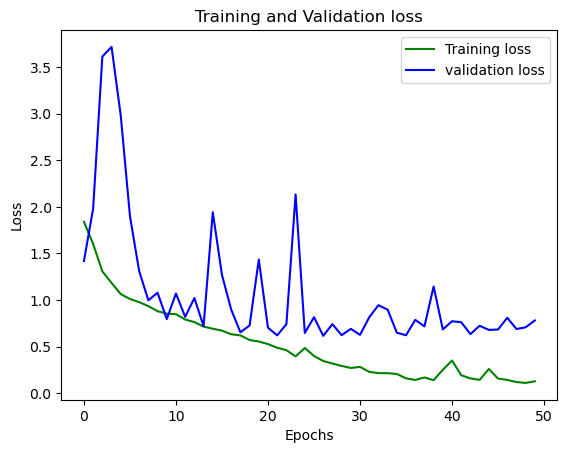

In [22]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

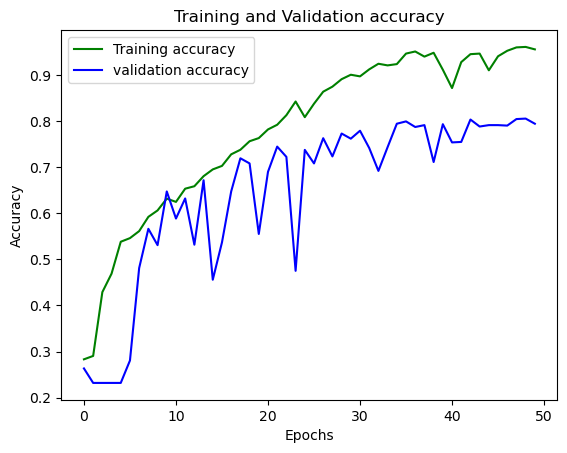

In [23]:
acc_train = history.history['acc']
acc_val = history.history['val_acc']
epochs = range(0,50)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [49]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 172, 172, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 86, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 84, 84, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d (SeparableConv2D)   │ (None, 84, 84, 128)         │           8,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_1 (SeparableConv2D) │ (None, 84, 84, 128)         │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 84, 84, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 42, 42, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_2 (SeparableConv2D) │ (None, 42, 42, 256)         │          34,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_3 (SeparableConv2D) │ (None, 42, 42, 256)         │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 42, 42, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 21, 21, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 21, 21, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_4 (SeparableConv2D) │ (None, 21, 21, 512)         │         133,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_5 (SeparableConv2D) │ (None, 21, 21, 512)         │         267,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 21, 21, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      52,429,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1024)                │           4,0

 Total params: 159,797,454 (609.58 MB)

 Trainable params: 53,264,324 (203.19 MB)

 Non-trainable params: 4,480 (17.50 KB)

 Optimizer params: 106,528,650 (406.37 MB)